# 비골절, 골절 Classifier

## colab 에서 진행할 경우 (이외 건너뛰어도 무방)
- 드라이브 마운트 필요

In [1]:
# to find the directory you're in ,
!ls
#if you wanna go into a folder (say samplefolder)
%cd /content/drive/My Drive

drive  sample_data
/content/drive/My Drive


In [2]:
import os
os.getcwd()

'/content/drive/My Drive'

In [0]:
# !unzip whole.zip -d whole

## Load module

In [3]:
from __future__ import print_function, division

from keras import optimizers, initializers, regularizers, metrics
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.models import Model
from keras.optimizers import RMSprop


# from functools import partial

import keras.backend as K

import matplotlib.pyplot as plt
from matplotlib.image import imread

# import os
import sys
import glob

import numpy as np

Using TensorFlow backend.


## Source Data 확인

/content/drive/My Drive/whole/x-ray/Normal_resize_reverse_crop

/content/drive/My Drive/whole/x-ray/fracture_resize_reverse_crop

In [0]:
path_normal ='./whole/x-ray/Normal_resize_reverse_crop'
path_fracture = './whole/x-ray/fracture_resize_reverse_crop'

In [0]:
normal_image_path_names = []
fracture_image_path_names = []

# Get Images in folders
for file_n in glob.glob(path_normal + '/*.jpg'):
  normal_image_path_names.append(file_n)

for file_f in glob.glob(path_fracture + '/*.jpg'):
  fracture_image_path_names.append(file_f)


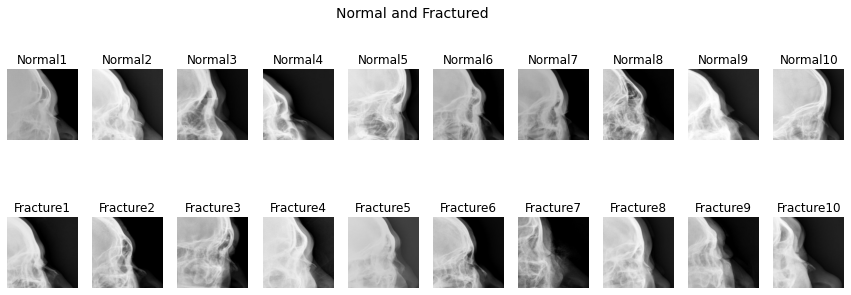

In [6]:
# Check if training data looks all right

fig, axs = plt.subplots(2, 10, figsize=(15, 5))
for i in range(10) :
  img_normal = imread(normal_image_path_names[i])
  img_fracture = imread(fracture_image_path_names[i])
  fig.suptitle('Normal and Fractured', fontsize=14)
  axs[0, i].set_axis_off()
  axs[0, i].set_title('Normal{}'.format(i+1))
  axs[0, i].imshow(img_normal, cmap='gray')
  axs[1, i].set_axis_off()
  axs[1, i].set_title('Fracture{}'.format(i+1))
  axs[1, i].imshow(img_fracture, cmap='gray')

In [7]:
print(img_normal.shape)
print(img_fracture.shape)

(224, 224, 3)
(224, 224, 3)


In [8]:
print(len(normal_image_path_names))
print(len(fracture_image_path_names))

693
1127


## Train set, Test set 디렉토리 분류
####  이미 디렉토리 안에 파일이 생성되어 있는 경우 지나가도 됨

 classifier\
   ├── test\
   │   ├── fracture\
   │   └── normal\
   └── train\
  ----      ├── fracture\
  ----      └── normal



Ref:\
https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/

In [9]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random

## Step1
# create directories
dataset_home = './whole/x-ray/classifier/'
subdirs = ['images/train/', 'images/test/']
labeldirs = ['fracture/', 'normal/']

for subdir in subdirs:
  for labeldir in labeldirs:
    newdir = dataset_home + subdir + labeldir
    makedirs(newdir, exist_ok=True)
print('== Step1 is done ==')


## Step2
# seed random number generator
seed(1)

# define ratio of pictures to use for validation
val_ratio = 0.2
# val_ratio = 0.3

# copy training dataset images into subdirectories

path_normal ='./whole/x-ray/Normal_resize_reverse_crop'
path_fracture = './whole/x-ray/fracture_resize_reverse_crop'


src_path = [path_fracture, path_normal]
for path in src_path:
  for file in listdir(path):
    src = path + '/' + file # './whole/x-ray/fracture_resize_reverse_crop/*.jpg'
    lab_dir = path.split('/')[-1].split('_')[0].lower() # fracture, normal
    if random() > val_ratio:
      subdir = 'images/train/'
      dst = dataset_home + subdir + lab_dir + '/'  + file # './whole/x-ray/classifier/images/클래스(fracture, normal)'
      copyfile(src, dst)
    else:
      subdir = 'images/test/'
      dst = dataset_home + subdir + lab_dir + '/'  + file # './whole/x-ray/classifier/images/클래스(fracture, normal)'
      copyfile(src, dst)
print('== Step2 is done ==')

== Step1 is done ==
== Step2 is done ==


Ref:\
https://github.com/lsjsj92/keras_basic/blob/master/6.%20predict_binary_img_with_CNN.ipynb

In [10]:
from PIL import Image
import os, glob, sys, numpy as np
from os import makedirs
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

img_dir = './whole/x-ray/classifier/images/train'
# categories = list(class_names)
categories = ['normal', 'fracture']
np_classes = len(categories)

img_w = 224
img_h = 224
channel = 3

pixel = img_w * img_h * channel

X = []
y = []

for idx, category in enumerate(categories):
  img_dir_detail = img_dir + '/' + category
  files = glob.glob(img_dir_detail + '/*.jpg')

  for i, f in enumerate(files):
    try:
      img = Image.open(f)
      img = img.convert('RGB')
      img = img.resize((img_w, img_h))
      data = np.asarray(img)
      # print(data.shape)
      X.append(data)
      y.append(idx)
      if i % 300 == 0:
        print(category, ":", f)
    except:
      print(category, str(i), 'Error')

X = np.array(X)
Y = np.array(y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

xy = (X_train, X_test, Y_train, Y_test)

normal : ./whole/x-ray/classifier/images/train/normal/1648r.jpg
normal : ./whole/x-ray/classifier/images/train/normal/283r.jpg
fracture : ./whole/x-ray/classifier/images/train/fracture/1367l.jpg
fracture : ./whole/x-ray/classifier/images/train/fracture/229r.jpg
fracture : ./whole/x-ray/classifier/images/train/fracture/1188l.jpg
fracture : ./whole/x-ray/classifier/images/train/fracture/1078l.jpg


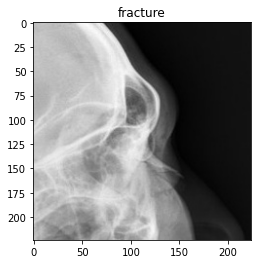

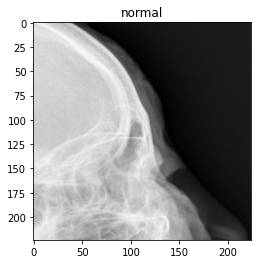

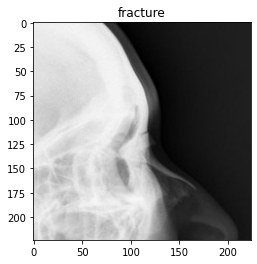

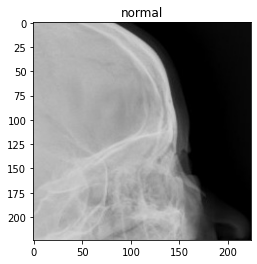

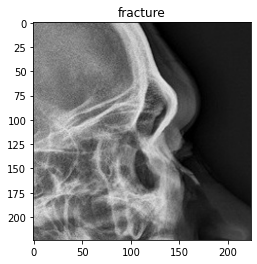

In [11]:
# Check X_train data by plotting

import random
import matplotlib.pyplot as plt
from matplotlib.image import imread

for i in range(5):
  ix = random.randint(1, X_train.shape[0])
  plt.imshow(X_train[ix])
  if Y_train[ix] == 0:
    plt.title('normal')
  elif Y_train[ix] == 1:
    plt.title('fracture')
  plt.show()

In [0]:
numpy_dir = './whole/x-ray/classifier/numpy_data'
numpy_data = './whole/x-ray/classifier/numpy_data/binary_image_data.npy'

In [0]:
makedirs(numpy_dir, exist_ok=True)
np.save(numpy_data, xy)

In [0]:
# from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K

In [15]:
X_train, X_test, y_train, y_test = np.load(numpy_data, allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])
print(np.bincount(y_train))
print(np.bincount(y_test))

(1326, 224, 224, 3)
1326
[497 829]
[57 91]


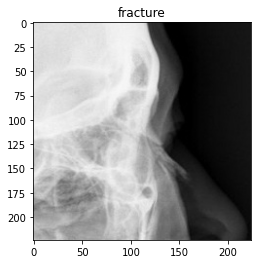

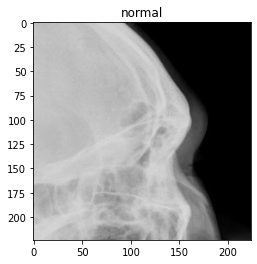

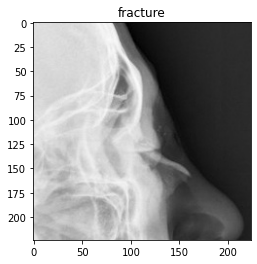

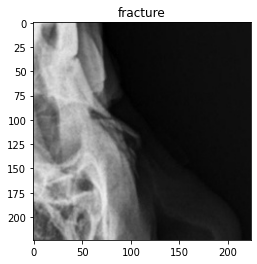

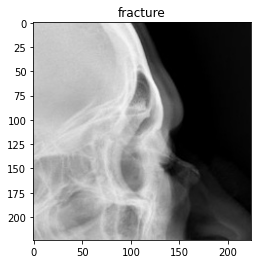

In [16]:
# Check X_train data by plotting

import random
import matplotlib.pyplot as plt
from matplotlib.image import imread

for i in range(5):
  ix = random.randint(1, X_train.shape[0])
  plt.imshow(X_train[ix])
  if Y_train[ix] == 0:
    plt.title('normal')
  elif Y_train[ix] == 1:
    plt.title('fracture')
  plt.show()

In [0]:
def classifier_model(img_size, channels):
    inputs = Input((img_size, img_size, channels))

    conv0 = Conv2D(8, (3,3), padding='same')(inputs)
    conv0 = LeakyReLU(0.2)(conv0)
    bat0 = BatchNormalization()(conv0)
    drop0 = Dropout(0.1)(bat0)
    # conv0 = Conv2D(8, (3,3), padding='same')(bat0)
    # conv0 = LeakyReLU(0.2)(conv0)
    # bat0 = BatchNormalization()(conv0)
    pool0 = MaxPooling2D(pool_size=(2,2))(drop0)
    drop0 = Dropout(0.1)(pool0)

    conv1 = Conv2D(16, (3,3), padding='same')(drop0)
    conv1 = LeakyReLU(0.2)(conv1)
    bat1 = BatchNormalization()(conv1)
    drop1 = Dropout(0.1)(bat1)
    # conv1 = Conv2D(16, (3,3), padding='same')(bat1)
    # conv1 = LeakyReLU(0.2)(conv1)
    # bat1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(drop1)
    drop1 = Dropout(0.1)(pool1)

    conv2 = Conv2D(32, (3,3), padding='same')(drop1)
    conv2 = LeakyReLU(0.2)(conv2)
    bat2 = BatchNormalization()(conv2)
    drop2 = Dropout(0.1)(bat2)
    # conv2 = Conv2D(32, (3,3), padding='same')(bat2)
    # conv2 = LeakyReLU(0.2)(conv2)
    # bat2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(drop2)
    drop2 = Dropout(0.1)(pool2)

    conv3 = Conv2D(64, (3,3), padding='same')(drop2)
    conv3 = LeakyReLU(0.2)(conv3)
    bat3 = BatchNormalization()(conv3)
    drop3 = Dropout(0.1)(bat3)
    # conv3 = Conv2D(64, (3,3), padding='same')(bat3)
    # conv3 = LeakyReLU(0.2)(conv3)
    # bat3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(drop3)
    drop3 = Dropout(0.1)(pool3)

    conv4 = Conv2D(128, (3,3), padding='same')(drop3)
    conv4 = LeakyReLU(0.2)(conv4)
    bat4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.1)(bat4)
    # conv4 = Conv2D(128, (3,3), padding='same')(bat4)
    # conv4 = LeakyReLU(0.2)(conv4)
    # bat4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(drop4)
    drop4 = Dropout(0.1)(pool4)

    conv5 = Conv2D(256, (3,3))(drop4)
    conv5 = LeakyReLU(0.2)(conv5)
    bat5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.1)(bat5)
    conv5 = Conv2D(256, (3,3))(drop5)
    conv5 = LeakyReLU(0.2)(conv5)
    bat5 = BatchNormalization()(conv5)
    pool5 = MaxPooling2D(pool_size=(2,2))(bat5)
    drop5 = Dropout(0.1)(pool5)

    fc = Flatten()(drop5)
    fc = Dense(512, kernel_regularizer=regularizers.l2(0.01))(fc)
    fc = LeakyReLU(0.2)(fc)
    fc = Dropout(0.5)(fc)
    fc = Dense(1)(fc)
    outputs = Activation('sigmoid')(fc)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

In [0]:
_, _, image_size, channels = X_train.shape
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [73]:
classifier = classifier_model(image_size, channels)
classifier.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 224, 224, 8)       104       
_________________________________________________________________
leaky_re_lu_129 (LeakyReLU)  (None, 224, 224, 8)       0         
_________________________________________________________________
batch_normalization_115 (Bat (None, 224, 224, 8)       32        
_________________________________________________________________
dropout_105 (Dropout)        (None, 224, 224, 8)       0         
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 112, 112, 8)       0         
_________________________________________________________________
dropout_106 (Dropout)        (None, 112, 112, 8)       0  

In [0]:
model_dir = './whole/x-ray/classifier/model'
makedirs(model_dir, exist_ok=True)

model_path = model_dir + "/fracture_normal_classify_model_{val_loss:.2f}.model"
# model_path = model_dir + "/fracture_normal_classify_model.model"
    
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
# checkpoint = ModelCheckpoint(filepath=model_path, monitor='accuracy', verbose=1, save_best_only=True)
# checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=False, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=30)

In [69]:
history = classifier.fit(X_train, y_train, batch_size=1, epochs=100, validation_split=0.3, callbacks=[checkpoint, early_stopping])
# history = classifier.fit(X_train, y_train, batch_size=1, epochs=100, validation_split=0.15, callbacks=[checkpoint, early_stopping])

Train on 928 samples, validate on 398 samples
Epoch 1/100
928/928 [==============================] - 21s 23ms/step - loss: 1.9276 - accuracy: 0.6272 - val_loss: 2.2404 - val_accuracy: 0.3894

Epoch 00001: saving model to ./whole/x-ray/classifier/model/fracture_normal_classify_model.model
Epoch 2/100
928/928 [==============================] - 19s 21ms/step - loss: 0.7391 - accuracy: 0.6886 - val_loss: 2.4219 - val_accuracy: 0.3894

Epoch 00002: saving model to ./whole/x-ray/classifier/model/fracture_normal_classify_model.model
Epoch 3/100
928/928 [==============================] - 19s 20ms/step - loss: 0.6758 - accuracy: 0.6778 - val_loss: 1.0253 - val_accuracy: 0.5025

Epoch 00003: saving model to ./whole/x-ray/classifier/model/fracture_normal_classify_model.model
Epoch 4/100
928/928 [==============================] - 18s 20ms/step - loss: 0.6521 - accuracy: 0.7015 - val_loss: 1.7471 - val_accuracy: 0.5779

Epoch 00004: saving model to ./whole/x-ray/classifier/model/fracture_normal_cla

KeyboardInterrupt: ignored

In [58]:
print("정확도 : %.2f " %(classifier.evaluate(X_test, y_test)[1]))

148/148 [==============================] - 0s 1ms/step
정확도 : 0.72 


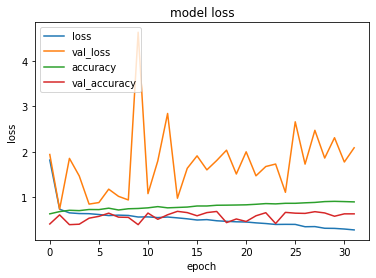

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.plot(history.history['acc'])
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_acc'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', 'accuracy', 'val_accuracy'], loc='upper left')
plt.show()

## Test 디렉토리 내 파일로 모델 검증하기

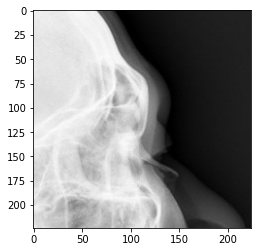

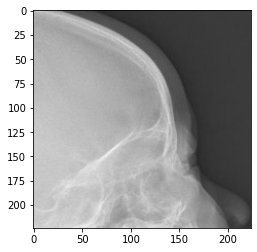

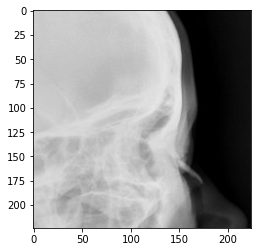

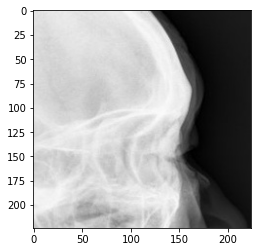

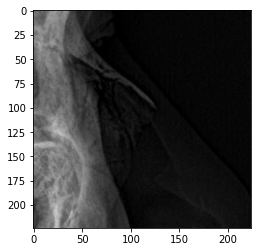

In [62]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

# import tensorflow as tf

seed = 5
# tf.set_random_seed(seed)
np.random.seed(seed)

caltech_dir = './whole/x-ray/classifier/images/test'


img_w = 224
img_h = 224
channel = 3

pixels = img_h * img_w * channel

X = []
filenames = []
files = glob.glob(caltech_dir + "/*/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((img_w, img_h))
    data = np.asarray(img)

    filenames.append(f)
    X.append(data)

X = np.array(X)

import random
import matplotlib.pyplot as plt
from matplotlib.image import imread

for i in range(5):
  ix = random.randint(1, X.shape[0])
  plt.imshow(X[ix])
  plt.show()

In [26]:
print(X.shape)

(533, 224, 224, 3)


In [63]:
X = X.astype(float) / 255
# model = load_model('./whole/x-ray/classifier/model/fracture_normal_classify.model')
model = load_model('./whole/x-ray/classifier/model/fracture_normal_classify_model.model')

prediction = model.predict(X)

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

result = []
cnt = 0
for i in prediction:
    if i >= 0.5:
      print("해당 " + filenames[cnt].split("/")[-2] + ' ' + filenames[cnt].split("/")[-1] + "  이미지는 1: 골절 로 추정됩니다.")
    else :
      print("해당 " + filenames[cnt].split("/")[-2] + ' ' + filenames[cnt].split("/")[-1] + "  이미지는 0: 비골절 로 추정됩니다.")
    cnt += 1

해당 fracture 1426l.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1469r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1346r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1293r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 109l.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1322r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1407l.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1707l.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1331l.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1465r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 115l.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 220r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 199r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 187r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 198l.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 194r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 226r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 188l.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 157r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 208r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 1l.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 140l.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 198r.jpg  이미지는 1: 골절 로 추정됩니다.
해당 fracture 141l.jpg  이미지는 

In [65]:
print(prediction)

[[1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 [1.000]
 

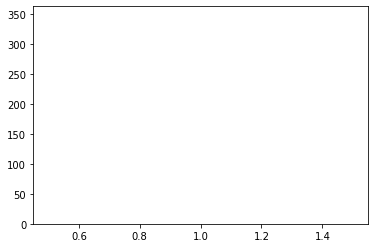

In [64]:
plt.hist(prediction, bins=X.shape[0])
plt.show()